In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import accuracy_score

# READ FROM DATABASE

In [277]:
import psycopg2

In [278]:
# jdbc:postgresql://pg-graduate-delt.postgres.database.azure.com:5432/{your_database}?user=snartimaal&password={your_password}&sslmode=require
with psycopg2.connect(
    database='pgsql-graduate-gruppe3',
    user='snartimaal',
    password='#st44p44nu',
    host='pg-graduate-delt.postgres.database.azure.com'
) as conn:
    cur = conn.cursor()

### Mattilsynet 

In [298]:
try:
    cur = conn.cursor()
    df_sql_mat = pd.read_sql_query("SELECT m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN company_subunit cs ON oj.orgnumber = cs.organisasjonsnummer ;", 
                                  conn)
except:
    conn.rollback()
    cur.close()

C:\Users\STM\AppData\Local\Temp\ipykernel_3804\320550458.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_mat = pd.read_sql_query("SELECT m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \


### Styremedlemmer

In [297]:
try:
    cur = conn.cursor()
    df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN styremedlem_junction sj ON oj.orgnumber = sj.organisasjonsnummer \
                                  JOIN people p ON sj.person_id = p.person_id ;", 
                                  conn)
except:
    conn.rollback()
    cur.close()


C:\Users\STM\AppData\Local\Temp\ipykernel_3804\2516288090.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \


### Google Review

In [350]:
try:
    cur = conn.cursor()
    df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \
                                 FROM google_review gr;", 
                                 conn)
except:
    conn.rollback()
    cur.close()


C:\Users\STM\AppData\Local\Temp\ipykernel_3804\2155275846.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \


In [361]:
avg_df = df_sql_reviews.groupby('orgnummer').mean()
min_max_df = (df_sql_reviews.groupby('orgnummer').max()) - (df_sql_reviews.groupby('orgnummer').min())
min_max_df['dif_rating'] = min_max_df.pop('individual_rating')
avg_df['avg_rating'] = avg_df.pop('individual_rating')

In [364]:
df_sql_mat

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode
0,915937144,368,2,21112022,1,69.0,56.101
1,974999439,366,0,23012020,0,17.0,47.241
2,915893848,369,0,14092017,1,25.0,56.101
3,919228660,178,0,21082018,1,7.0,56.101
4,912240770,1081,0,26112018,1,80.0,55.101
...,...,...,...,...,...,...,...
5836,915465870,194,0,19012023,1,34.0,56.101
5837,996480550,190,1,01092022,0,4.0,56.102
5838,913536835,194,0,09092022,0,4.0,56.101
5839,929774671,179,1,12122022,0,21.0,56.101


In [371]:
df_test = pd.merge(df_sql_mat, avg_df, how='left', on='orgnummer')
df_test = pd.merge(df_test, min_max_df, how='left', on='orgnummer')

In [373]:
df_test.isnull().sum()

orgnummer               0
postnr                  0
total_karakter          0
dato                    0
tilsynsbesoektype       0
antallansatte           0
naeringskode1_kode      0
avg_rating            658
dif_rating            658
dtype: int64

In [374]:
mean_avg = df_test['avg_rating'].mean()
mean_dif = df_test['dif_rating'].mean()
dt_test = df_test['avg_rating'].fillna(value=mean_avg, inplace=True)
dt_test = df_test['dif_rating'].fillna(value=mean_dif, inplace=True)

In [375]:
df_test

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000
1,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000
2,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000
3,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000
4,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000
...,...,...,...,...,...,...,...,...,...
5836,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158
5837,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000
5838,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000
5839,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000


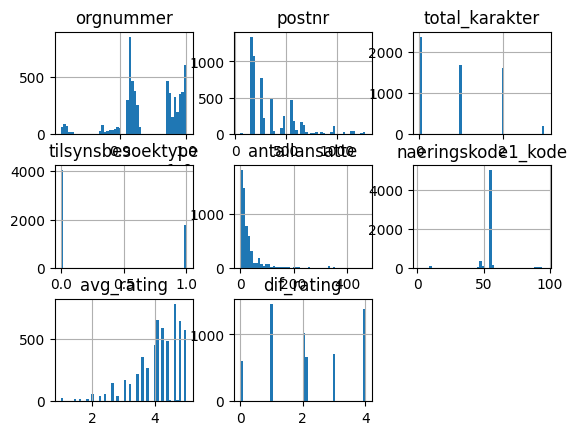

In [376]:
df_test.hist(bins=50)
plt.show()

# DATA PREP

In [377]:
# Endre dato til kun år ? De 4 siste sifrene 
dato = df_test['dato']
year_list = []

for i in dato.values:
    year_list.append(i[-4:])

df_test['dato'] = year_list

In [378]:
df_test

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915937144,368,2,2022,1,69.0,56.101,4.400000,2.000000
1,974999439,366,0,2020,0,17.0,47.241,4.000000,2.000000
2,915893848,369,0,2017,1,25.0,56.101,4.600000,1.000000
3,919228660,178,0,2018,1,7.0,56.101,4.800000,1.000000
4,912240770,1081,0,2018,1,80.0,55.101,3.200000,3.000000
...,...,...,...,...,...,...,...,...,...
5836,915465870,194,0,2023,1,34.0,56.101,4.096913,2.154158
5837,996480550,190,1,2022,0,4.0,56.102,2.400000,4.000000
5838,913536835,194,0,2022,0,4.0,56.101,5.000000,0.000000
5839,929774671,179,1,2022,0,21.0,56.101,2.600000,4.000000


In [379]:
ss_features = ['postnr', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']
ss_scaler = StandardScaler()
ss_scaler.fit(df_test[ss_features])
transformed_ss = ss_scaler.transform(df_test[ss_features])
df_test[ss_features] = transformed_ss

# TRAIN TEST SPLIT

In [380]:
features_test = df_test[['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']]
X = np.c_[features_test]
y = np.c_[df_test['total_karakter']]

In [381]:
print(f'X len : {len(X)}')
print(f'y len : {len(y)}')

X len : 5841
y len : 5841


In [382]:
print(X.data.shape,
y.data.shape)

(5841, 8) (5841, 1)


In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [384]:
print(f'X_train len : {len(X_train)}')
print(f'X_test len : {len(X_test)}')
print(f'y_train len : {len(y_train)}')
print(f'y_test len : {len(y_test)}')

X_train len : 4672
X_test len : 1169
y_train len : 4672
y_test len : 1169


In [385]:
print(X_train.shape, y_train.shape)

(4672, 8) (4672, 1)


# Naiv score

In [386]:
pred_naiv = np.mean(y_train)
y_pred_naiv = np.full(y_test.shape, pred_naiv)
print(f'y_pred_naiv : {len(y_pred_naiv)}') # 1169

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
print(f'Naiv MSE : {np.sqrt(mse_naiv)}') # 0.9147

mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
print(f'Naiv MAE : {mae_naiv}') # 0.7819

y_pred_naiv : 1169
Naiv MSE : 0.9006779223397954
Naiv MAE : 0.7660455751901285


# XGBoost Model

In [405]:
regressor = xgb.XGBRegressor(
    early_stopping_rounds = 20,
    max_depth = 5
)

regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = [['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']])


[0]	validation_0-rmse:0.89225
[1]	validation_0-rmse:0.84256
[2]	validation_0-rmse:0.81511
[3]	validation_0-rmse:0.80044
[4]	validation_0-rmse:0.79408
[5]	validation_0-rmse:0.79113
[6]	validation_0-rmse:0.79000
[7]	validation_0-rmse:0.78762
[8]	validation_0-rmse:0.78656
[9]	validation_0-rmse:0.78694
[10]	validation_0-rmse:0.78874
[11]	validation_0-rmse:0.79011
[12]	validation_0-rmse:0.78927
[13]	validation_0-rmse:0.78731
[14]	validation_0-rmse:0.78679
[15]	validation_0-rmse:0.78735
[16]	validation_0-rmse:0.78553
[17]	validation_0-rmse:0.78464
[18]	validation_0-rmse:0.78292
[19]	validation_0-rmse:0.78321
[20]	validation_0-rmse:0.78323
[21]	validation_0-rmse:0.78269
[22]	validation_0-rmse:0.78366
[23]	validation_0-rmse:0.78539
[24]	validation_0-rmse:0.78461
[25]	validation_0-rmse:0.78380
[26]	validation_0-rmse:0.78422
[27]	validation_0-rmse:0.78452
[28]	validation_0-rmse:0.78550
[29]	validation_0-rmse:0.78535
[30]	validation_0-rmse:0.78555
[31]	validation_0-rmse:0.78552
[32]	validation_0-

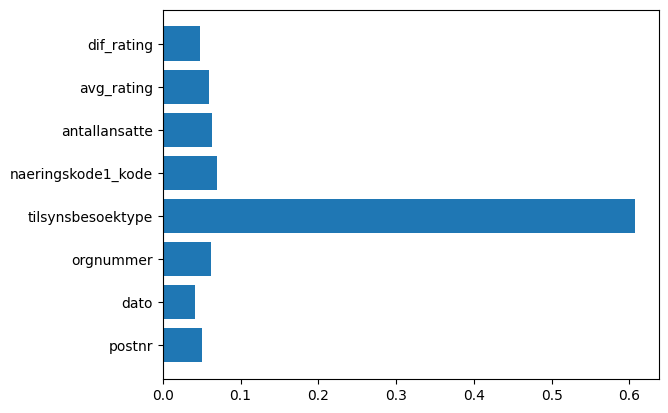

In [406]:
plt.barh(['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating'], regressor.feature_importances_)
plt.show()

# Scoring xg

In [407]:
# Train xg
r2_train_xg = regressor.score(X_train, y_train)
print(f'Train R2 XG : {r2_train_xg}') # 6f 0.3071 / m.år 0.4545

y_pred_train_xg = regressor.predict(X_train)
mse_train_xg = mean_squared_error(y_train, y_pred_train_xg)
print(f'Train MSE XG : {np.sqrt(mse_train_xg)}') # 6f 0.7480 / m.år 0.6641

mae_train_xg = mean_absolute_error(y_train, y_pred_train_xg)
print(f'Train MAE XG : {mae_train_xg}') # 6f 0.5854 / m.år 0.5156

# Test xg
r2_test_xg = regressor.score(X_test, y_test)
print(f'Test R2 XG : {r2_test_xg}') # 6f 0.1754 / m.år 0.2766

y_pred_test_xg = regressor.predict(X_test)
mse_test_xg = mean_squared_error(y_test, y_pred_test_xg)
print(f'Test MSE XG : {np.sqrt(mse_test_xg)}') # 6f 0.8305 / m.år 0.7755

mae_test_xg = mean_absolute_error(y_test, y_pred_test_xg)
print(f'Train MAE XG : {mae_test_xg}') # 6f 0.6631 / m.år 0.6029

Train R2 XG : 0.38478069476236365
Train MSE XG : 0.7077448662370226
Train MAE XG : 0.5578138689251481
Test R2 XG : 0.24274149169844328
Test MSE XG : 0.7826877100816388
Train MAE XG : 0.6215949538633884


# Linear Regression Model

In [408]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_test, y_test)

## TRAIN

r2_train = lin_reg_model.score(X_train, y_train)
y_train_pred_linreg = lin_reg_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred_linreg)
mse_train = mean_squared_error(y_train, y_train_pred_linreg)
print(f'Train R2 : {r2_train}') # 0.1616 / 6f 0.17036 / m.år 0.1595
print(f'Train MAE : {mae_train}') # 0.6758 / 6f 0.6559 / m.år 0.6557
print(f'Train MSE : {np.sqrt(mse_train)}') # 0.8256 / 6f 0.8185 / m.år 0.8244

## TEST

r2_test = lin_reg_model.score(X_test, y_test)
y_test_pred_linreg = lin_reg_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred_linreg)
mse_test = mean_squared_error(y_test, y_test_pred_linreg)
print(f'Test R2 : {r2_test}') # 0.1802 / 6f 0.1664 / m.år 0.2152
print(f'Test MAE : {mae_test}') # 0.6662 / 6f 0.6802 / m.år 0.6399
print(f'Test MSE : {np.sqrt(mse_test)}') # 0.8164 / 6f 0.8351 / m.år 0.8077

Train R2 : 0.1636780337635183
Train MAE : 0.6484330281431596
Train MSE : 0.8251796368545354
Test R2 : 0.21284780435746342
Test MAE : 0.6289915502809369
Test MSE : 0.7979869503130939


# Logistic Regression Model

C:\Users\STM\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy : 0.5344606164383562
Train Precision : 0.0
Train Recall : 0.0


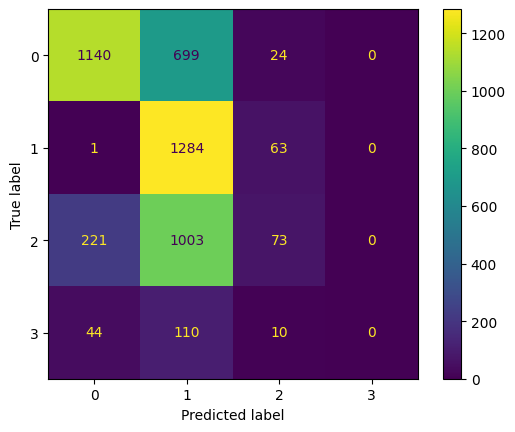

In [409]:
# y_train = y_train.reshape(-1)
log_reg_model = LogisticRegression(max_iter = 1000)
log_reg_model.fit(X_train, y_train)

y_pred_cm = log_reg_model.predict(X_train)
#y_train_pred_prod = log_reg_model.predict_proba(X_train)
#y_train_pred_prod_1 = y_train_pred_prod[:,1]
#y_train_pred = y_train_pred_prod_1 > 0.1

train_acc = accuracy_score(y_train, y_pred_cm)
print(f'Train accuracy : {train_acc}')

cm_train = confusion_matrix(y_train, y_pred_cm)

tn_train = cm_train[0,0]
fp_train = cm_train[1,1]
fn_train = cm_train[2,2]
tp_train = cm_train[3,3]

precision_train = tp_train/(tp_train+fp_train)
recall_train = tp_train/(tp_train+fn_train)
print(f'Train Precision : {precision_train}')
print(f'Train Recall : {recall_train}')

ConfusionMatrixDisplay(cm_train).plot()
plt.show()

# KNeighbors Regressor Model

In [410]:
model_knn = KNeighborsRegressor(n_neighbors=15)
model_knn.fit(X_train, y_train)

# KNN score
# Train
R2_train_knn = model_knn.score(X_train, y_train)
y_pred_train_knn = model_knn.predict(X_train)
mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
print(f'Knn Train Score:')
print(f'R2_train : {R2_train_knn}') # 0.3681
print(f'MAE train : {mae_train_knn}') # 0.5506
print(f'MSE train : {np.sqrt(mse_train_knn)}') # 0.7171

# Test
R2_test_knn = model_knn.score(X_test, y_test)
y_test_pred_knn = model_knn.predict(X_test)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
print(f'Knn Test Score:')
print(f'R2_test : {R2_test_knn}') # 0.1192
print(f'MAE test : {mae_test_knn}') # 0.6579
print(f'MSEtest : {np.sqrt(mse_test_knn)}') # 0.8453

Knn Train Score:
R2_train : 0.2557777919326105
MAE train : 0.6222174657534246
MSE train : 0.7784183462416602
Knn Test Score:
R2_test : 0.1864537931882898
MAE test : 0.6497861420017109
MSEtest : 0.8112552978285682
